# Potential Talent






## Background

#### As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

#### The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

#### We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

#### Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

## Goals
#### - Predict how fit the candidate is based on their available information (variable fit)
#### - Rank candidates based on a fitness score.
#### - Re-rank candidates when a candidate is starred.

## Setup

In [1]:
#install libraries
!pip install pycaret
!pip install imbalanced-learn
!pip install optuna lightgbm
!pip install duckdb

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import warnings
import logging
import random
import lightgbm as lgb
import requests
import sys
import optuna
import duckdb as dd
import umap
import regex as re
import plotly.express as px
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, make_scorer, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text
from sklearn.feature_selection import RFE
from pycaret.datasets import get_data
from pycaret.classification import setup, compare_models, predict_model
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# code to suppress lightGBM when running Lazy Classifer
class CustomLogger:
    def __init__(self):
        self.logger = logging.getLogger('lightgbm_custom')
        self.logger.setLevel(logging.ERROR)

    def info(self, message):
        self.logger.info(message)

    def warning(self, message):
        pass# Suppress warnings by not doing anything pass

    def error(self, message):
        self.logger.error(message)
# Register the custom logger
lgb.register_logger(CustomLogger())

### Data extraction

In [4]:
file_path = '/content/Extended Dataset for Potential Talents.xlsx'

df = pd.read_excel(file_path)
df


,id,title,location,screening_score
0,1,innovative and driven professional seeking a r...,United States,100
1,2,ms applied data science student usc research a...,United States,100
2,3,computer science student seeking full-time sof...,United States,100
3,4,microsoft certified power bi data analyst mba ...,United States,100
4,5,graduate research assistant at uab masters in ...,United States,100
...,...,...,...,...
1280,1281,GenAINLPCVML Senior AI Engineer Data Scientist...,India,0
1281,1282,Data Scientist and Analyst Driving Business In...,Kenya,0
1282,1283,Software Engineer WriterSpace Science Enthusiast,Ethiopia,0
1283,1284,Master Trainer of Big Data Analytics Data Scie...,Jordan,0


## Exploratory Data Analysis

### Data Validation

In [5]:
# check for missing values
df.isnull().sum()

,0
id,0
title,4
location,0
screening_score,0


In [6]:
# check data types
df.dtypes

,0
id,int64
title,object
location,object
screening_score,int64


In [7]:
print(df.describe())
print(df.describe(include=['object']))

                id  screening_score
count  1285.000000      1285.000000
mean    643.000000        62.613230
std     371.091857        32.177719
min       1.000000         0.000000
25%     322.000000        30.000000
50%     643.000000        80.000000
75%     964.000000        90.000000
max    1285.000000       100.000000
               title       location
count           1281           1285
unique          1206             40
top     data analyst  United States
freq              19           1127


In [8]:
for col in df.columns:
  print(f"Unique values for column '{col}':")
  print(df[col].unique())
  print("-" * 20)


Unique values for column 'id':
[   1    2    3 ... 1283 1284 1285]
--------------------
Unique values for column 'title':
['innovative and driven professional seeking a role in data analyticsdata science in the information technology industry.'
 'ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025'
 'computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs'
 ... 'Software Engineer WriterSpace Science Enthusiast'
 'Master Trainer of Big Data Analytics Data Scientist'
 'Digital Marketing Strategist Growth Performance Marketing SEO PPC Social Media Expert']
--------------------
Unique values for column 'location':
['United States' 'United Kingdom' 'Brazil' 'Austria'
 'United Arab Emirates' 'China' 'Germany' 'Pakistan' 'India' 'Egypt'
 'Ethiopia' 'Kenya' 'Indonesia' 'Philippines' 

### Data Wrangling

In [9]:
# show rows with null values
df[df.isnull().any(axis=1)]

,id,title,location,screening_score
14,15,NaN,United States,100
193,194,NaN,Austria,50
248,249,NaN,United States,30
587,588,NaN,United States,85


In [10]:
print('Before removing nulls: ', len(df))
# remove null rows as missing title info will be of no value for analysis.
df = df.dropna()
print('After removing nulls: ', len(df))
df

Before removing nulls:  1285
After removing nulls:  1281


,id,title,location,screening_score
0,1,innovative and driven professional seeking a r...,United States,100
1,2,ms applied data science student usc research a...,United States,100
2,3,computer science student seeking full-time sof...,United States,100
3,4,microsoft certified power bi data analyst mba ...,United States,100
4,5,graduate research assistant at uab masters in ...,United States,100
...,...,...,...,...
1280,1281,GenAINLPCVML Senior AI Engineer Data Scientist...,India,0
1281,1282,Data Scientist and Analyst Driving Business In...,Kenya,0
1282,1283,Software Engineer WriterSpace Science Enthusiast,Ethiopia,0
1283,1284,Master Trainer of Big Data Analytics Data Scie...,Jordan,0


In [11]:
# check for missing values
df.isnull().sum()

,0
id,0
title,0
location,0
screening_score,0


In [12]:
print('Total rows: ', len(df))
# Assuming df is your DataFrame and 'title' is the column name
def check_title(title):
    if pd.isna(title):
        return True  # Consider missing values as invalid
    match = re.search(r"^[^a-zA-Z0-9]", str(title))
    return bool(match)

df['invalid_title'] = df['title'].apply(check_title)

# Display rows with invalid titles

print('# of rows with non-alpha characters at beginning of title', len(df[df['invalid_title']]))
df[df['invalid_title']]

Total rows:  1281
# of rows with non-alpha characters at beginning of title 17


,id,title,location,screening_score,invalid_title
131,132,--,United States,80,True
172,173,--,United States,80,True
175,176,.,United States,75,True
384,385,--,United States,100,True
431,432,--,United States,95,True
498,499,-data scientist analytics transforming busines...,United States,95,True
574,575,--,United States,90,True
711,712,--,United States,80,True
714,715,--,United States,80,True
818,819,--,United States,80,True


In [13]:
### function to remove non-alphanumeric characters at beggining of title.
def clean_title(text):
  # Regular expression to match '-' or '.' not preceded by a letter
  pattern = r"(?<!\w)[-.]"
  return re.sub(pattern, "", text)


# Example usage with your DataFrame
df['title'] = df['title'].apply(clean_title)
df = df[df['title'].astype(str).str.strip() != '']
print('Total rows after cleaning: ', len(df))

Total rows after cleaning:  1265


In [14]:
# recheck for invalid titles
df['invalid_title'] = df['title'].apply(check_title)

# Display rows with invalid titles

print('# of rows with non-alpha characters at beginning of title', len(df[df['invalid_title']]))
df[df['invalid_title']]


# of rows with non-alpha characters at beginning of title 0


,id,title,location,screening_score,invalid_title


### Data Visualization

#### Word Cloud

In [15]:
# Join titles
text = df['title'].str.cat(sep=' ')

text

'innovative and driven professional seeking a role in data analyticsdata science in the information technology industry. ms applied data science student usc research assistant usc former data analytics intern at dr reddys laboratories former data science intern quadratyx actively seeking full time roles in summer 2025 computer science student seeking full-time software engineerdeveloper positions ai sql data visualization toolspython ssrs microsoft certified power bi data analyst mba business analytics unt business intelligence engineer data scientist data engineer business analytics predictive analytics statistical analysis ex-ericsson graduate research assistant at uab masters in data science student at uab ex jio student at kennesaw state university data analyst business analyst python snowflake sql machine learning power bi tableau equipped with analytics driven by insights and passionate about impactful solutions. graduate research aide student at arizona state university data sci

In [16]:
# set stop words
stopwords = set(STOPWORDS)

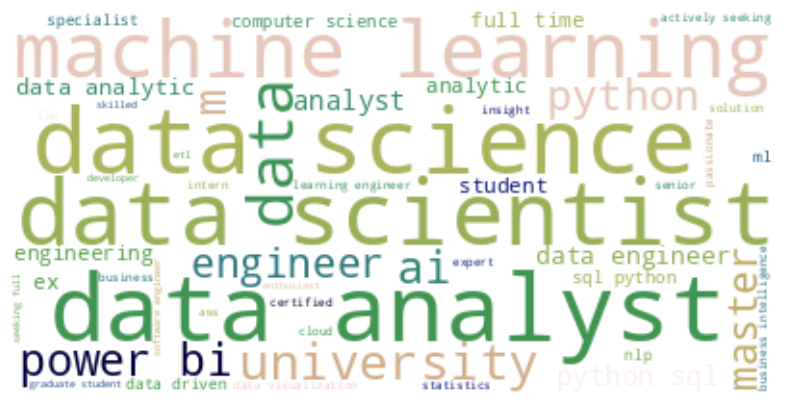

In [17]:
# size of word cloud
plt.figure(figsize=(10, 5))

# make wordcloud
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color='white', colormap='gist_earth').generate(text)

# plot wprd cloud
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

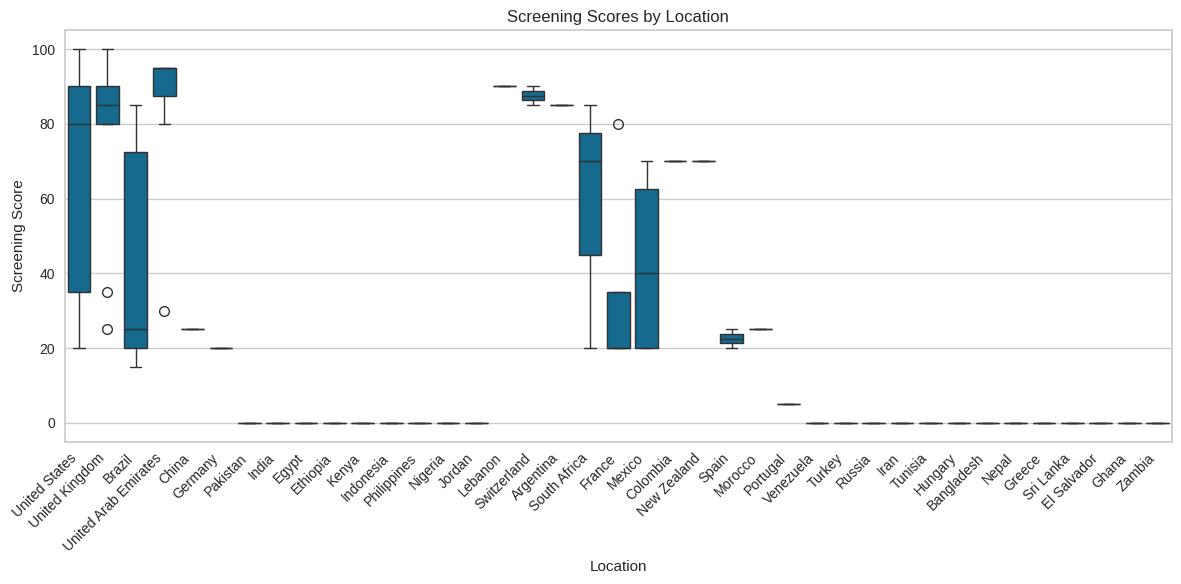

In [18]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='location', y='screening_score', data=df)
plt.title('Screening Scores by Location')
plt.xlabel('Location')
plt.ylabel('Screening Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [19]:
# prompt: create a chloropeth plot of id count by country reducing  impact of highest country on coloring

import plotly.express as px

# Assuming 'df' is your DataFrame and it contains 'location' and 'id' columns
# Group by location and count the number of IDs
location_id_counts = df.groupby('location')['id'].count().reset_index()
location_id_counts.rename(columns={'id': 'id_count'}, inplace=True)

# Find the maximum ID count to adjust the color scale
max_id_count = location_id_counts['id_count'].max()

# Apply a logarithmic transformation to reduce the impact of the highest country
location_id_counts['log_id_count'] = np.log1p(location_id_counts['id_count'])

# Create the choropleth plot using plotly express
fig = px.choropleth(location_id_counts,
                    locations='location',  # Assuming 'location' column contains country codes or names
                    locationmode='country names',  # Set locationmode accordingly
                    color='log_id_count',  # Use log-transformed ID count for coloring
                    hover_name='location',  # Hover information
                    hover_data={'id_count': True}, # Show both log and raw counts on hover
                    color_continuous_scale='Viridis',  # Customize the color scale
                    title='ID Count by Country (Logarithmic Scale)',
                    range_color=(location_id_counts['log_id_count'].min(), location_id_counts['log_id_count'].max())) # Set range for consistent color scale
fig.show()


In [20]:
# prompt: create a chloropeth plot of average screening score by country

import plotly.express as px

# Assuming 'df' is your DataFrame and it contains 'location' and 'screening_score' columns
# Group by location and calculate the average screening score
location_score_avg = df.groupby('location')['screening_score'].mean().reset_index()
location_score_avg.rename(columns={'screening_score': 'avg_screening_score'}, inplace=True)

# Create the choropleth plot using plotly express
fig = px.choropleth(location_score_avg,
                    locations='location',  # Assuming 'location' column contains country codes or names
                    locationmode='country names',  # Set locationmode accordingly
                    color='avg_screening_score',  # Use average screening score for coloring
                    hover_name='location',  # Hover information
                    color_continuous_scale='Viridis',  # Customize the color scale
                    title='Average Screening Score by Country')
fig.show()


## TF-IDF

In [21]:
# generate a random seed number

random.seed()
seed = random.randint(0, 1000)  # Generates a random integer between 0 and 1000
seed


751

In [22]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['title'],
                                                    df['screening_score'],
                                                    test_size=0.2,
                                                    random_state=seed)

In [23]:
X_train_vectorized = TfidfVectorizer(min_df=5, stop_words='english').fit(X_train)
len(X_train_vectorized.get_feature_names_out())

253

In [24]:
feature_names = np.array(X_train_vectorized.get_feature_names_out())

# Calculate the TF-IDF matrix
tfidf_matrix = X_train_vectorized.transform(X_train)

# Get the maximum TF-IDF values for each feature (column)
max_tfidf_values = tfidf_matrix.max(0).toarray()[0]

# Get the indices that would sort the maximum TF-IDF values
sorted_tfidf_index = max_tfidf_values.argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['hadoop' 'spark' 'drive' 'actionable' 'transforming' 'driving' 'rag'
 'strategic' 'decision' 'airflow']

Largest tfidf: 
['researcher' 'data' 'statistics' 'statistician' 'skills' 'scientist'
 'science' 'certified' 'computational' 'cs']


In [25]:
# Create and train the model
lr = LogisticRegression(random_state=seed)
lr.fit(X_train_vectorized.transform(X_train), y_train)  # Replace X_train_vectorized with your TF-IDF vectorizer and X_train, y_train with your data

# get list of features with min and max coefficients
sorted_coef_index = lr.coef_[0].argsort()

print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['aws' 'ms' 'visualization' 'analytics' 'graduate' 'seeking' 'tableau'
 'azure' 'actively' 'opportunities']

Largest Coefs: 
['scientist' 'learning' 'engineer' 'processing' 'developer' 'mlops'
 'automation' 'artificial' 'security' 'ml']


In [26]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'title' column to create the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['title'])

# Get the title of the document with id 1
title_id_1 = df[df['id'] == 1]['title'].iloc[0]

# Transform the title of id 1 using the same vectorizer
title_id_1_vector = tfidf_vectorizer.transform([title_id_1])

# Calculate the cosine similarity between the title of id 1 and all other titles
cosine_similarities = cosine_similarity(title_id_1_vector, tfidf_matrix)

# Add cosine similarities to the dataframe
df['cosine_similarity'] = cosine_similarities[0]

df



,id,title,location,screening_score,invalid_title,cosine_similarity
0,1,innovative and driven professional seeking a r...,United States,100,False,1.000000
1,2,ms applied data science student usc research a...,United States,100,False,0.077896
2,3,computer science student seeking full-time sof...,United States,100,False,0.064870
3,4,microsoft certified power bi data analyst mba ...,United States,100,False,0.014957
4,5,graduate research assistant at uab masters in ...,United States,100,False,0.050998
...,...,...,...,...,...,...
1280,1281,GenAINLPCVML Senior AI Engineer Data Scientist...,India,0,False,0.019146
1281,1282,Data Scientist and Analyst Driving Business In...,Kenya,0,False,0.044282
1282,1283,Software Engineer WriterSpace Science Enthusiast,Ethiopia,0,False,0.030826
1283,1284,Master Trainer of Big Data Analytics Data Scie...,Jordan,0,False,0.020133


In [27]:
sort_df = df.sort_values(by='cosine_similarity', ascending=False)
sort_df


,id,title,location,screening_score,invalid_title,cosine_similarity
0,1,innovative and driven professional seeking a r...,United States,100,False,1.000000
162,163,data engineer information technology,United States,80,False,0.350977
692,693,software engineer business intelligence bs in ...,United States,80,False,0.271903
561,562,data science ai professional expert in machine...,United States,90,False,0.262693
223,224,data scientist results-driven ai professional ...,United States,35,False,0.241465
...,...,...,...,...,...,...
752,753,biomedical engineer thermo fisher scientific,United States,80,False,0.000000
749,750,fixed-term assistant professor at michigan sta...,United States,80,False,0.000000
747,748,it customer support specialist ii,United States,80,False,0.000000
745,746,clinical specialist at quantum surgical,United States,80,False,0.000000
